In [1]:
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv("train_model/data/bitcoin_2017_to_2023.csv")

df = df.dropna()
df = df.reset_index(drop=True)

df["timestamp"] = df["timestamp"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

df = df.sort_values(by=["timestamp"])
# df = df.drop(columns=["timestamp"])
df = df.reset_index(drop=True)

df_len = len(df)
test_size = 0.2
cut_idx = int(df_len* (1 - test_size))
train, val = df.iloc[:cut_idx], df.iloc[cut_idx:]

In [2]:
numeric_cols = ['open']#, 'high', 'low', 'close'] 
       #          'volume', 'quote_asset_volume',
       # 'number_of_trades', 'taker_buy_base_asset_volume',
       # 'taker_buy_quote_asset_volume']

scaler = MinMaxScaler(feature_range=(-1, 1))

In [20]:
from tslearn.metrics import dtw
import numpy as np
from tqdm import tqdm
from heapq import heappop, heappush

window_size = 100
stride = 50
k = 20
for index in range(0, len(train), stride):
    arr_data = train.iloc[index:index + window_size][numeric_cols].values
    arr_data = scaler.fit_transform(arr_data)

    top_k = []
    for target_index in tqdm(range(0, len(train), stride)):
        if index == target_index:
            continue
        
        arr_target = train.iloc[target_index:target_index + window_size][numeric_cols].values
        arr_target = scaler.fit_transform(arr_target)
        target_start_date = train.iloc[target_index]["timestamp"]
        cost = dtw(arr_data, arr_target)#, global_constraint="sakoe_chiba", sakoe_chiba_radius=5)

        if len(top_k) < k:
            heappush(top_k, (-cost, target_index))
        else:
            if -cost > top_k[0][0]:
                heappop(top_k)
                heappush(top_k, (-cost, target_index))

    top_k = sorted(top_k, key=lambda x: x[0], reverse=True)
        
    break

100%|██████████| 50016/50016 [01:01<00:00, 814.62it/s]


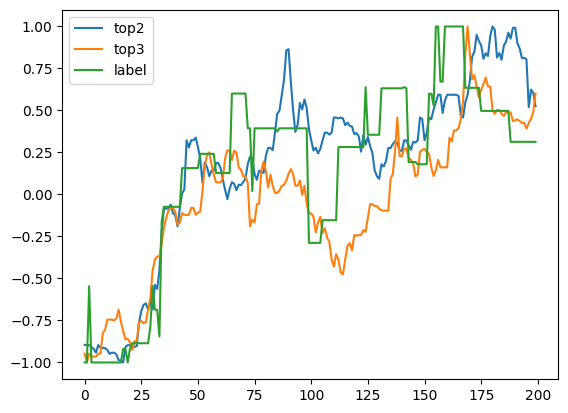

In [26]:
import matplotlib.pyplot as plt

def vis_preprocessing(start_idx, label_index, offset):
    target_data = train.iloc[start_idx: start_idx + window_size+offset]
    target_data = target_data.drop(columns=["timestamp"]).values
    target_data = scaler.fit_transform(target_data)
    target_data = target_data[:, label_index]

    return target_data

def top_k_vis(label_index, rank=[0, 1, 2, 3, 4], offset=10):
    for i in rank:
        start_idx = top_k[i][1]
        target_data = vis_preprocessing(start_idx=start_idx, label_index=label_index, offset=offset)
        plt.plot(target_data, label=f"top{i+1}")
        
    origin_data = vis_preprocessing(start_idx=0, label_index=label_index, offset=offset)
    plt.plot(origin_data, label="label")
    plt.legend()


top_k_vis(1, range(0, 5), 100)

In [23]:
for i in top_k:
    print(i[0])

-1.2182938477095426
-1.294955925293601
-1.2950674036671836
-1.3412670376252047
-1.343500923684878
-1.3493063170638073
-1.3495643620469784
-1.359989075033024
-1.3640451248282228
-1.3668119982080933
-1.3676442464753757
-1.3740690686747683
-1.3761892333276204
-1.383172012951551
-1.3928544509366494
-1.399890660883312
-1.4002754485466984
-1.4004053017452076
-1.4051814095073665
-1.4071905046607311
